# Introduction

`doubletdetection` is a classifier of doublets in scRNA-Seq data. This notebook details how to use `doubletdetection` as well as provides insight into how it works.

In [1]:
from doubletdetection import BoostClassifier
from doubletdetection import load_csv

# Miscellaneous imports
import phenograph
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import collections

%matplotlib inline

# Loading data

Data can be downloaded from the [10x website](https://support.10xgenomics.com/single-cell/datasets). We will be using the PBMC 4k dataset from 10x.

In [2]:
FNAME = "~/Google Drive/Computational Genomics/pbmc_4k_dense.csv"
raw_counts = load_csv(FNAME)

`raw_counts` is a count table of 3958 cells

# Running classification

In [3]:
clf = BoostClassifier(boost_rate=0.5, n_pca=20, knn=20)
labels = clf.fit(raw_counts)
print("Number of doublets =", np.sum(labels == 1))


Clustering mixed data set with Phenograph...

Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.22360610961914062 seconds
Jaccard graph constructed in 0.47667407989501953 seconds
Wrote graph to binary file in 0.22056794166564941 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.885981
Louvain completed 21 runs in 1.8008129596710205 seconds
PhenoGraph complete in 2.7881710529327393 seconds
Found communities [0, ... 21], with sizes: [1118, 777, 687, 406, 368, 307, 307, 303, 268, 262, 252, 201, 187, 98, 86, 79, 60, 58, 36, 30, 27, 20]


Number of doublets = 73


`labels` will contain a 1 for every cell (row in raw_counts) that has been identified as a doublet and 0 for singlet. These detected doublets have a score >= suggested_cutoff.

# Score Analysis

`doubletdetection` provides a sugggested cutoff score - a score for which every cell >= score is detected as a doublet. However, there is flexibility in choosing your cutoff. The scores can be analyzed as follows with the color orange in the bar chart representing synthetic doublets:

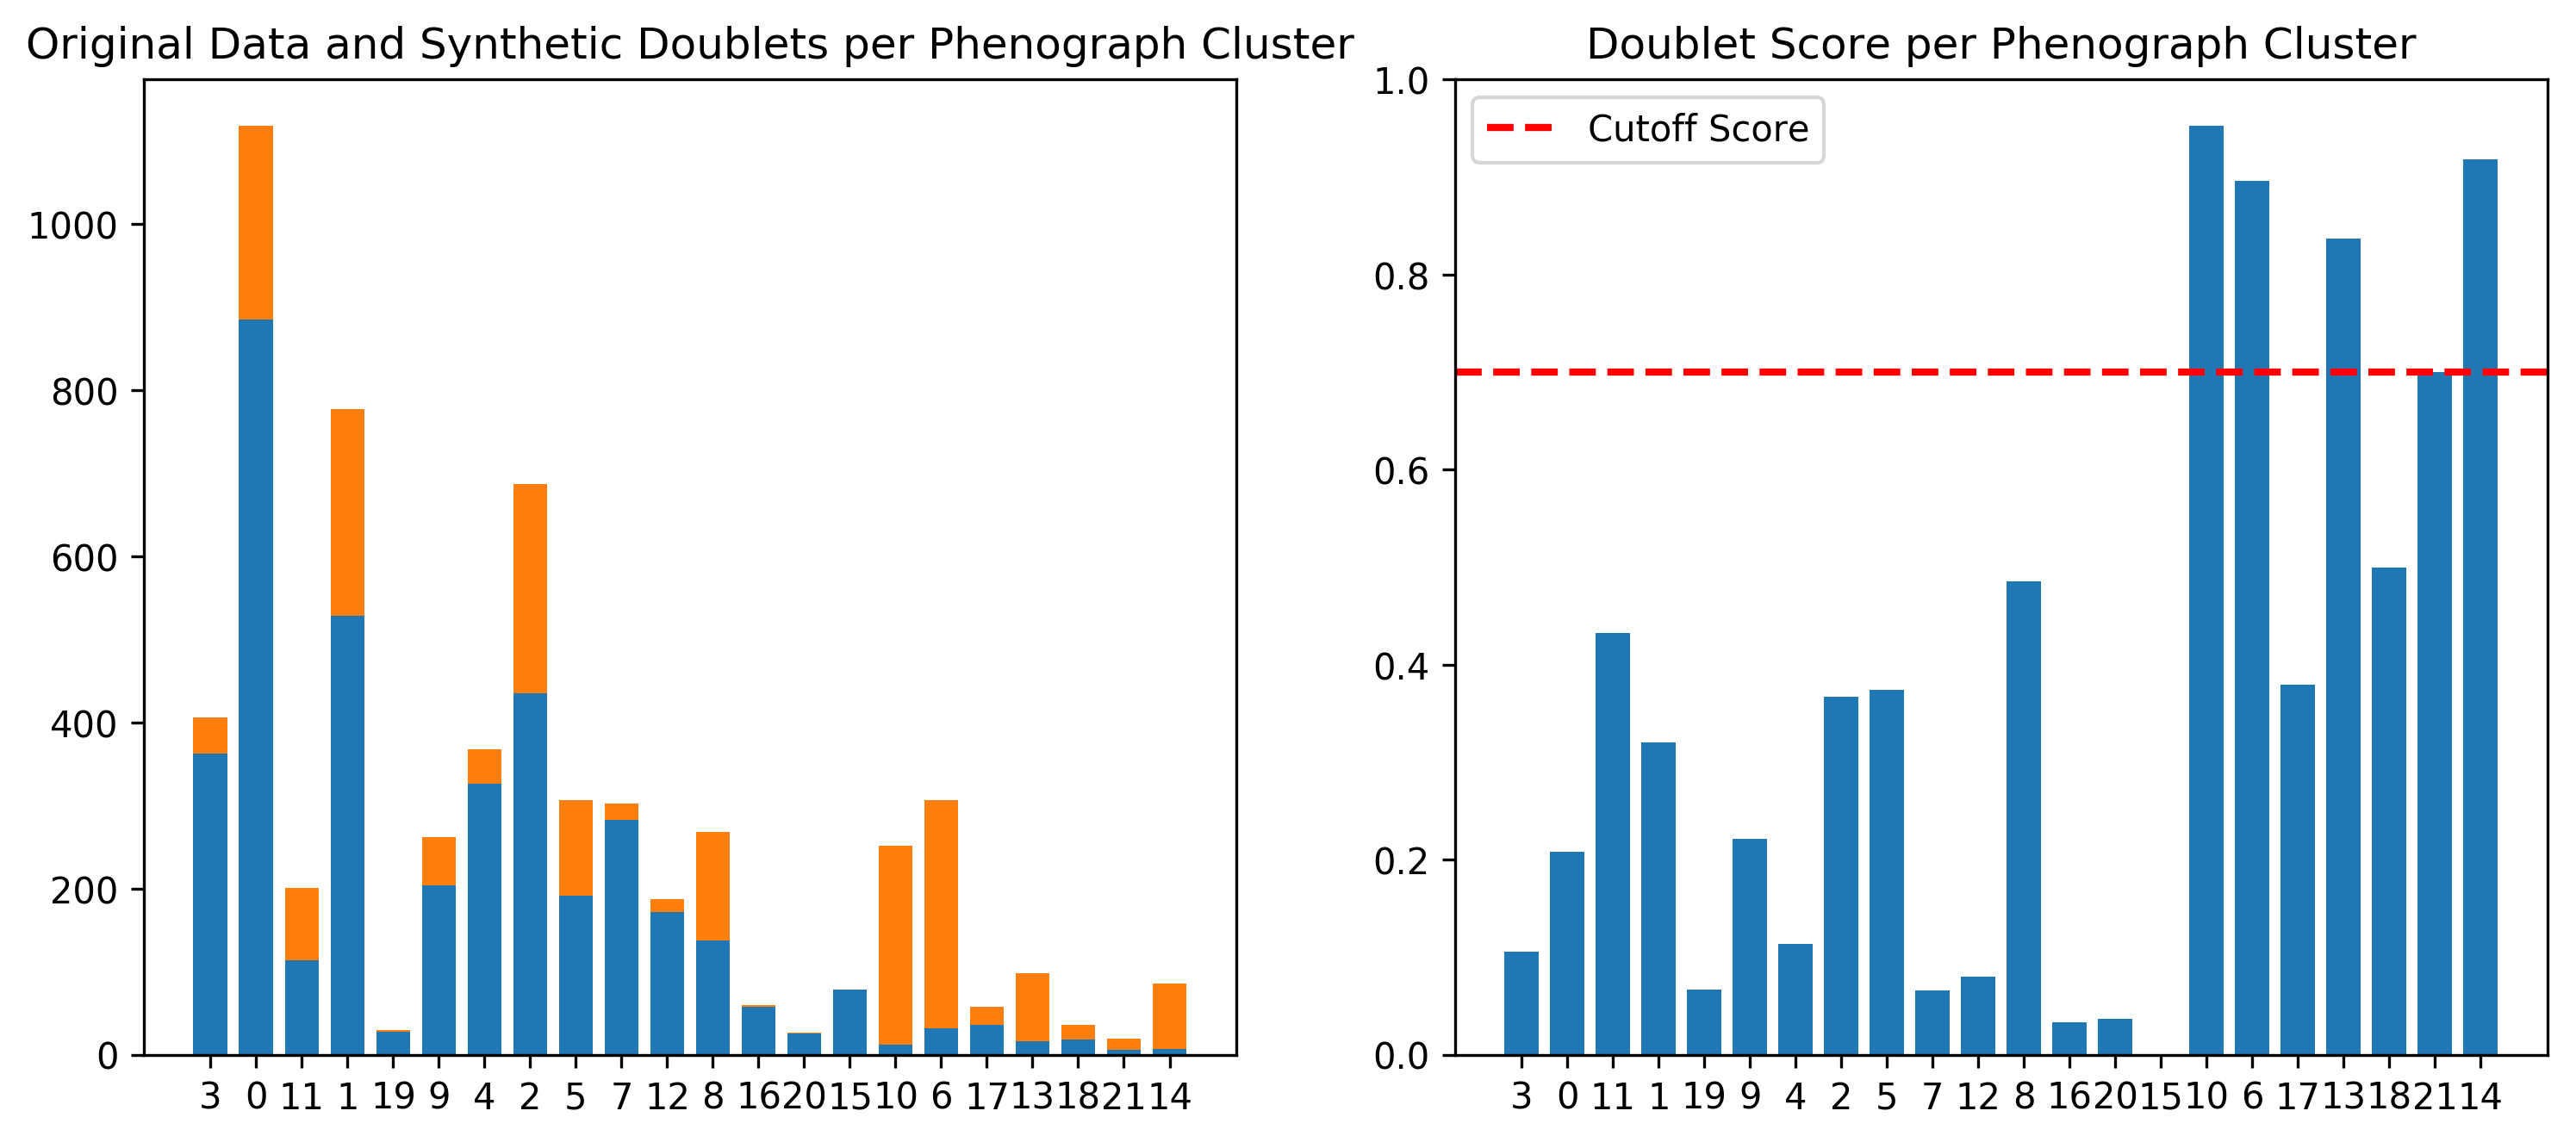

In [4]:
# Stacked histogram of number of original and synthetic data points per community
communities = clf.communities_
scores = clf.scores_

fig1 = plt.figure(figsize=(12, 5), dpi=300)
ax1 = plt.subplot(121)
raw_com_count = collections.Counter(communities)
doublet_com_count = collections.Counter(clf.synth_communities_)

coms, values = zip(*raw_com_count.items())
indexes = np.arange(len(coms))
width = 0.75
plt.bar(indexes, values, width)

synths = []
for com in coms:
    synths.append(doublet_com_count[com])
plt.bar(indexes, synths, width, bottom=values)

plt.xticks(indexes, coms)
ax1.set_title("Original Data and Synthetic Doublets per Phenograph Cluster")

# Histogram of scores per community
ax2 = plt.subplot(122)
coms, values = zip(*raw_com_count.items())
indexes = np.arange(len(coms))
width = 0.75

s = []
for com in coms:
    score = np.unique(scores[np.where(communities == com)[0]])
    s.append(score[0])

plt.bar(indexes, s, width)
plt.xticks(indexes, coms)
plt.axhline(np.floor(100 * clf.suggested_cutoff_) / 100, color='r', linestyle='dashed', linewidth=2,
                label='Cutoff Score')
plt.legend()
ax2.set_title("Doublet Score per Phenograph Cluster")


# Validation

We invite you to read the paper in the github repo to see our results after running on a dataset of two very different cell lines. The following example will give you some idea about the finer details of this process.

In [5]:
# First cleanse the dataset of detected doublets
detected_doublets = np.where(labels == 1)[0]
clean_counts = np.delete(raw_counts, detected_doublets, axis=0)

# Create new dataset with fake doublets that we will consider to be true
clean = BoostClassifier(boost_rate=0.05)
clean._raw_counts = clean_counts
(clean._num_cells, clean._num_genes) = clean_counts.shape
clean._createLinearDoublets()

# Add these doublets to the end of the clean dataset
aug_counts = np.append(clean_counts, clean.raw_synthetics_, axis=0)

# Visualize this dataset
# Get tsne
pca = PCA(n_components=30)
reduced_counts = pca.fit_transform(aug_counts)
        
tsne = TSNE(random_state=1)
tsne_counts = tsne.fit_transform(reduced_counts)

# Run Phenograph on aug_counts
aug_communities, _, _ = phenograph.cluster(reduced_counts, k=30)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.11204195022583008 seconds
Jaccard graph constructed in 0.4948909282684326 seconds
Wrote graph to binary file in 0.2723050117492676 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.842312
After 13 runs, maximum modularity is Q = 0.843771
Louvain completed 33 runs in 2.1475017070770264 seconds
PhenoGraph complete in 3.1337997913360596 seconds


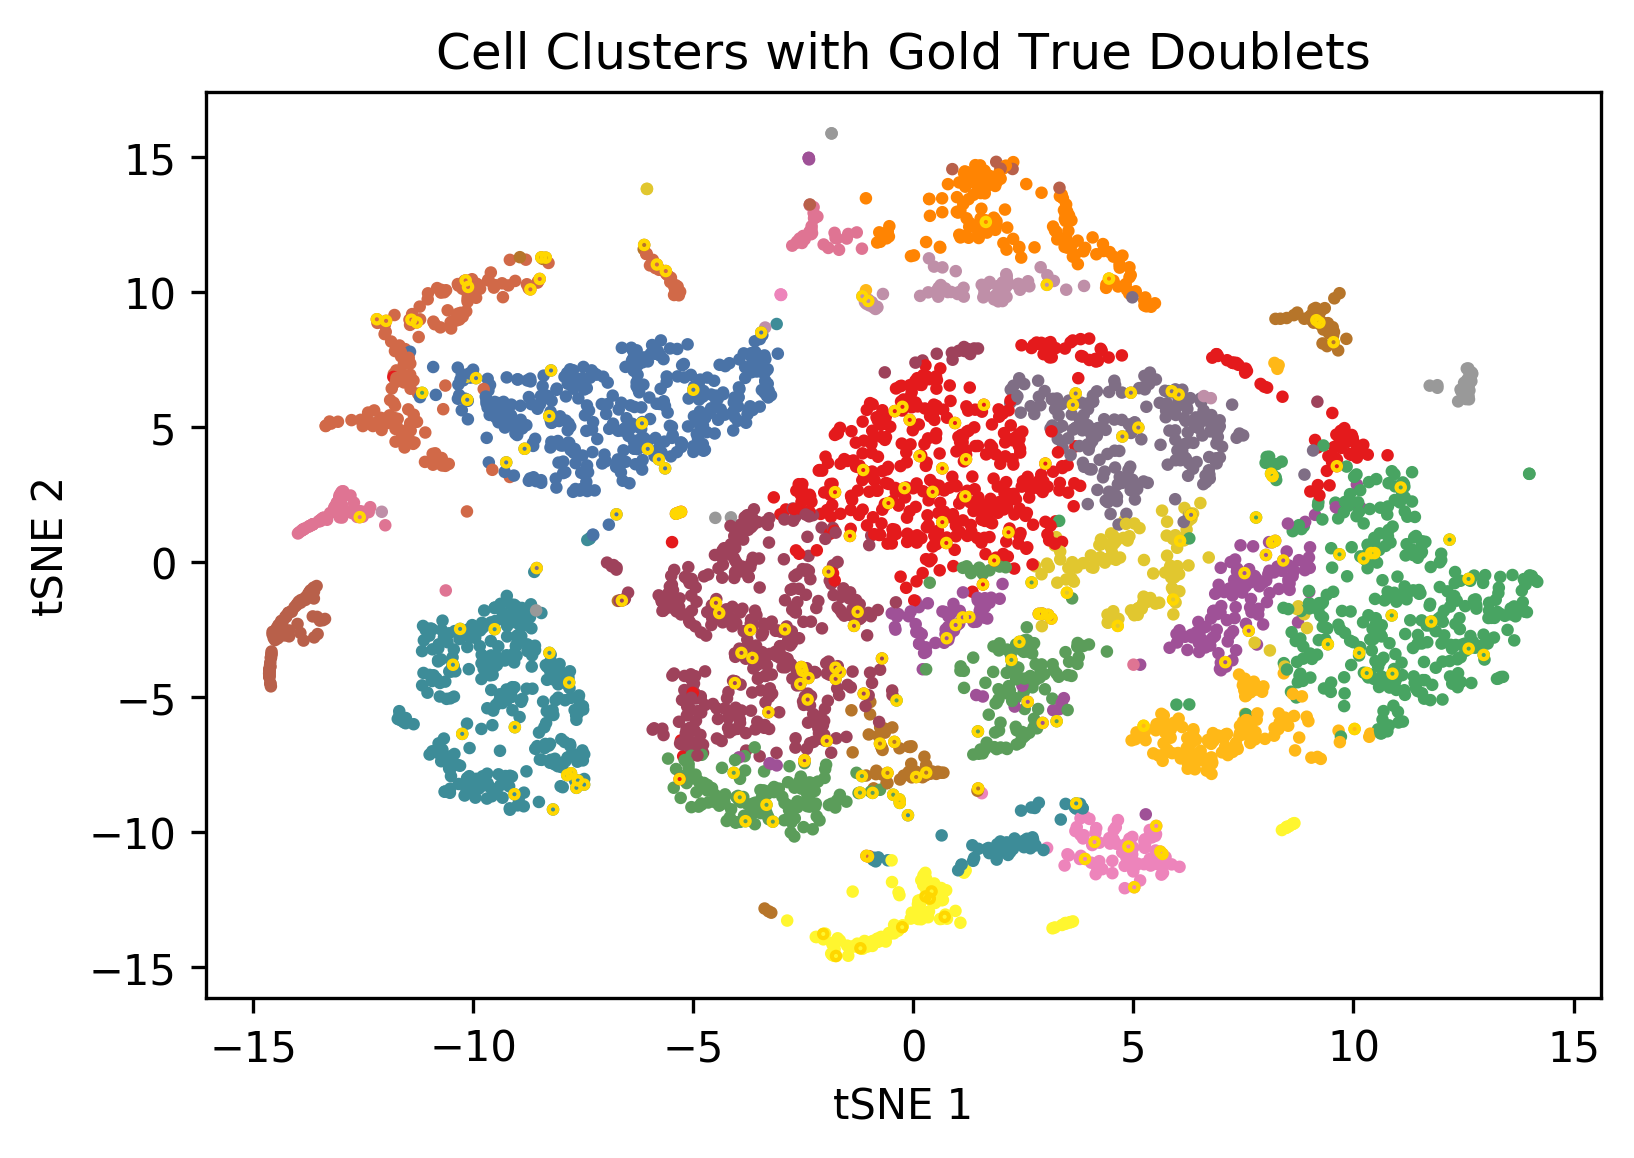

In [6]:
#Plot
fig = plt.figure(dpi=300)
set1i = LinearSegmentedColormap.from_list('set1i', plt.cm.Set1.colors, N=100)
colors = aug_communities
x = tsne_counts[:, 0]
y = tsne_counts[:, 1]
plt.scatter(x, y, c=colors, s=4, cmap=set1i)
true_doublets = np.arange(clean._num_cells, aug_counts.shape[0])
plt.scatter(x[true_doublets],y[true_doublets],facecolors='none',linewidth='1', edgecolors='gold', s=4)
plt.title("Cell Clusters with Gold True Doublets")
plt.xlabel("tSNE 1")
plt.ylabel("tSNE 2")

We immediately see that the doublets are scattered across the dataset. We will now run BoostClassify.fit() to show how the clusters change with the addition of fake doublets

In [7]:
clf = BoostClassifier(boost_rate=0.50, n_pca=30, knn=30)
labels = clf.fit(aug_counts)

counts = np.append(aug_counts, clf.raw_synthetics_, axis=0)
print("Number of doublets =", np.sum(labels == 1))


Clustering mixed data set with Phenograph...

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.4317612648010254 seconds
Jaccard graph constructed in 0.7054929733276367 seconds
Wrote graph to binary file in 0.4398770332336426 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.870812
Louvain completed 21 runs in 2.2185981273651123 seconds
PhenoGraph complete in 3.873453140258789 seconds
Found communities [0, ... 19], with sizes: [1235, 877, 624, 461, 457, 372, 330, 312, 282, 232, 229, 226, 167, 81, 76, 57, 32, 30, 20, 18]


Number of doublets = 69


In [8]:
# Data viz
pca = PCA(n_components=20)
reduced_counts = pca.fit_transform(counts)
        
tsne = TSNE(random_state=1)
tsne_counts = tsne.fit_transform(reduced_counts)

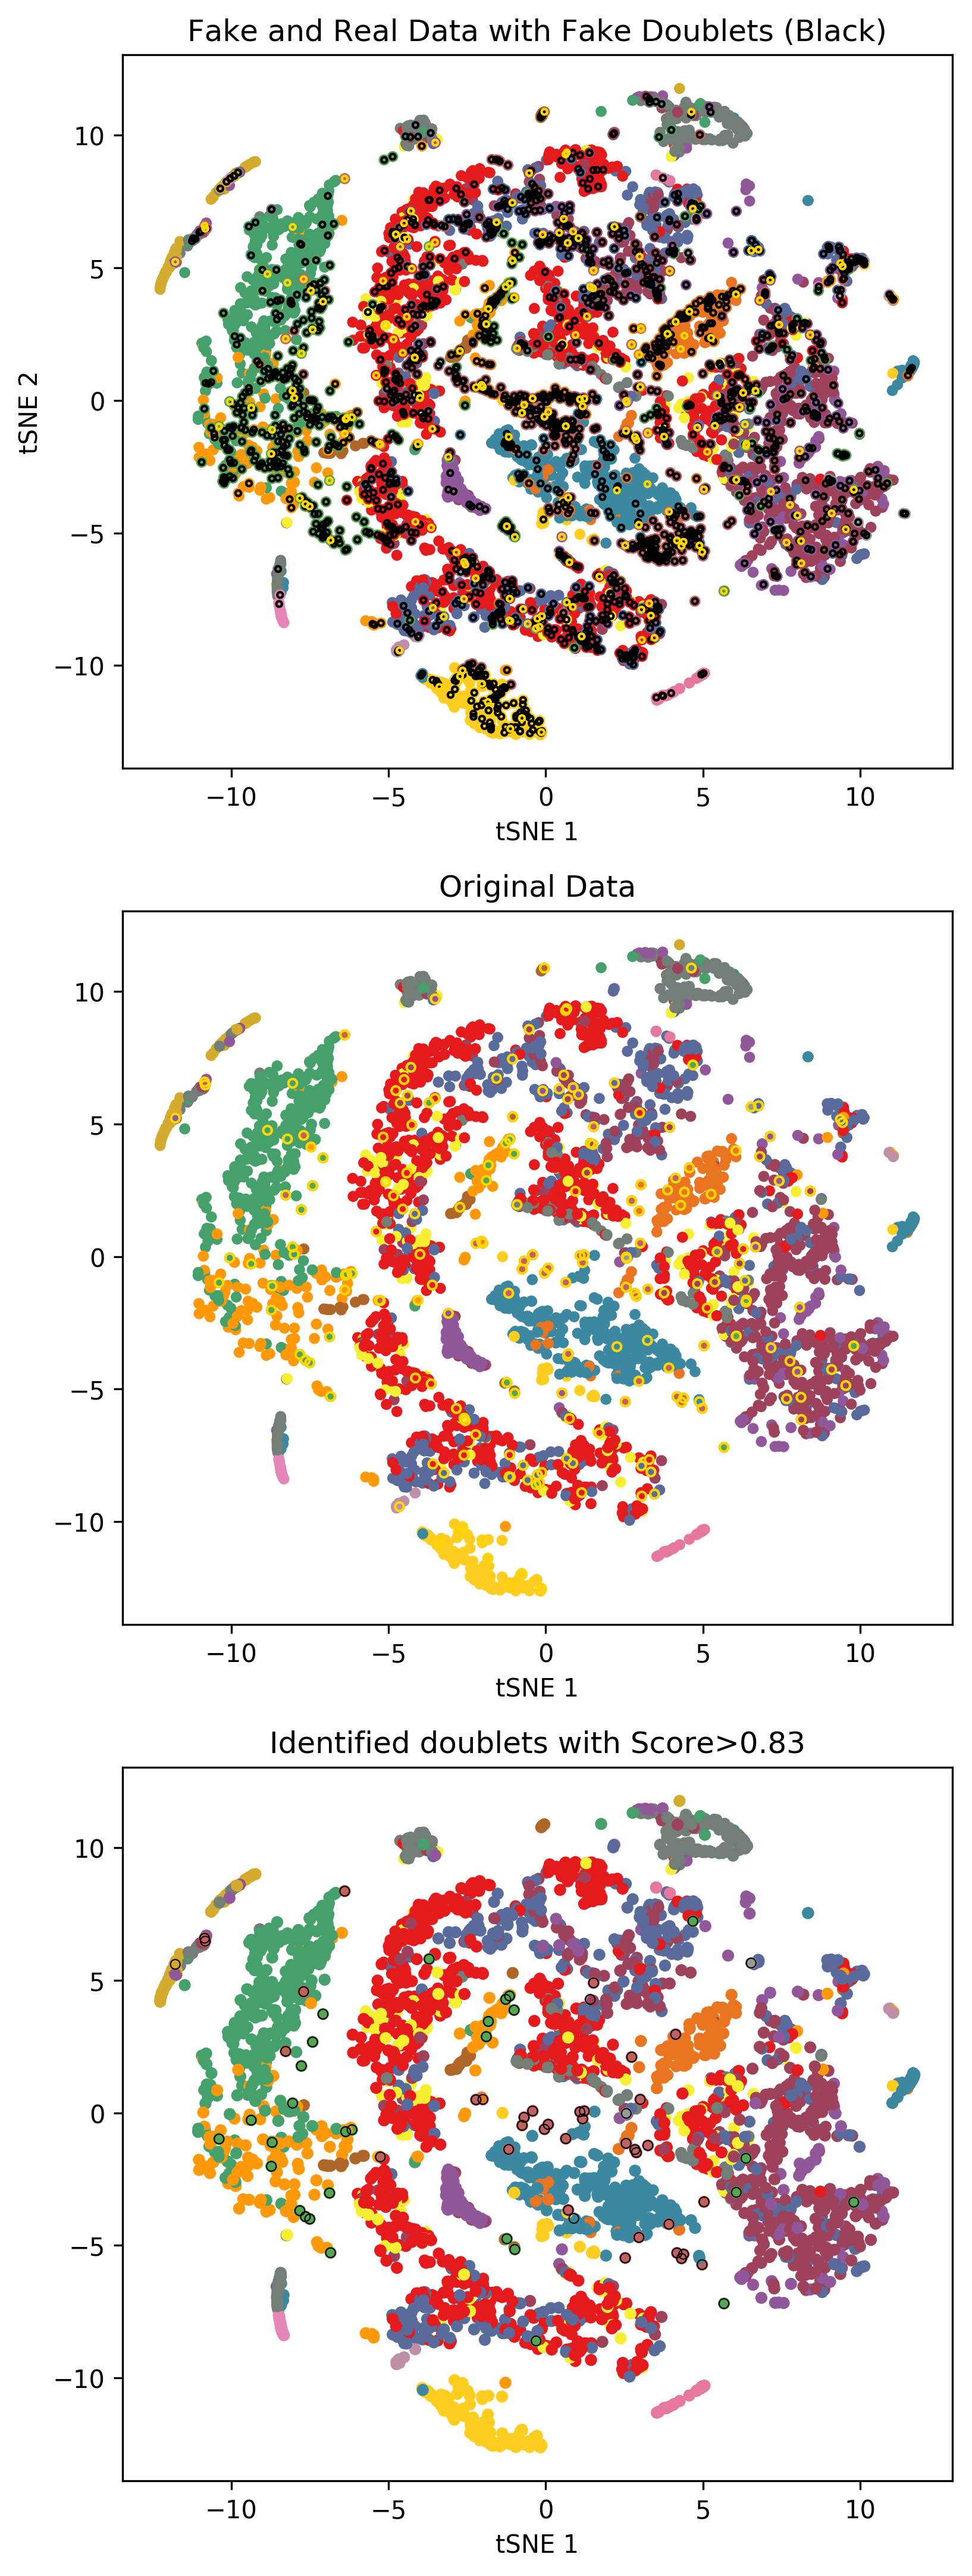

In [9]:
#Plot
set1i = LinearSegmentedColormap.from_list('set1i', plt.cm.Set1.colors, N=100)
f, (ax1, ax2, ax3) = plt.subplots(3,1, sharey=True, figsize=(6, 18), dpi=300)
colors = np.append(clf.communities_, clf.synth_communities_)
x = tsne_counts[:,0]
y = tsne_counts[:,1]
ax1.scatter(x, y, c=colors, s=12, cmap=set1i)
# Added cells
ax1.scatter(x[clf._num_cells:], y[clf._num_cells:], facecolors='none',linewidth='1', edgecolors='black', s=5)
# True doublets
ax1.scatter(x[true_doublets],y[true_doublets], facecolors='none', linewidth='1', 
    edgecolors='gold', s=5)
ax1.set_title("Fake and Real Data with Fake Doublets (Black)")
ax1.set_xlabel("tSNE 1")
ax1.set_ylabel("tSNE 2")
        
# Original Data
colors = clf.communities_
ax2.scatter(x[:aug_counts.shape[0]], y[:aug_counts.shape[0]], c=colors, s=12, cmap=set1i)
ax2.scatter(x[true_doublets],y[true_doublets],facecolors='none', linewidth='1', 
    edgecolors='gold', s=12)
ax2.set_title("Original Data")
ax2.set_xlabel("tSNE 1")
      
# Original marked doublets
ax3.scatter(x[:aug_counts.shape[0]], y[:aug_counts.shape[0]], c=colors, s=15, cmap=set1i)
cutoff = clf.suggested_cutoff_
doublets = np.where(labels == 1)[0]
ax3.scatter(x[doublets], y[doublets], facecolors='none', linewidth='0.5', edgecolors='black', s=15)
ax3.set_title("Identified doublets with Score>" + str(round(cutoff,2)))
ax3.set_xlabel("tSNE 1")

In the first plot, we see the result of clustering the mixed dataset (original cells + synthetic doublets in black). We can see pockets where black synthetic doublets cluster with the gold synthetic doublets that we are treating as true doublets. In the second plot, we see just the original data, (same as the first plot with the black points removed). In the third plot, we can see the points we identified as doublets with a black ring around them. The takeaway here is that adding the black points in the first plot fundamentally changes the local neighborhood structure for the real doublets. Take the cluster surrounding the aqua blue cluter near the middle (this cluster is reddish in color). We see that this cluster is almost entirely made up of doublets. Hence, Phenograph identifies "doublet clusters", resulting from the boosting in the signal of synthetic doublets. With the scoring, we can easily identify those clusters. See below for precision and recall of this experiment.

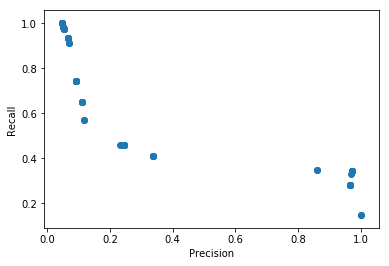

In [10]:
prec = []
rec = []
for s in range(0, 100, 1):
    cutoff = s / float(100)
    detected_doublets = np.where(clf.scores_>=cutoff)[0]
            
    if len(detected_doublets) == 0:
        break
        
    precision = len(np.intersect1d(detected_doublets,true_doublets))/float(len(detected_doublets))
    prec.append(precision)
    recall = len(np.intersect1d(detected_doublets,true_doublets))/float(len(true_doublets))
    rec.append(recall)
            
    #print("Precision:", precision)
    #print("Recall:", recall)
            
plt.scatter(prec, rec)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.show()

Ideally, the recall would be higher, but ultimately the doublets we detect have very few false positives. We will continue to improve the methodology here, however we invite you to experiment with different parameters or preprocessing steps to get a better recall.